In [69]:
import numpy as np
import matplotlib.pyplot as plt

import KF_Library as kf

# Model parameters

In [70]:
l = 1
T = 100*l 
t1 = np.arange(T)
A = np.array([[0.8499, 0.0350, 0.0240, 0.0431],
              [1.2081, 0.0738, 0.0763, 0.4087],
              [0.7331, 0.0674, 0.0878, 0.8767],
              [0.0172, 0.0047, 0.0114, 0.9123]])

B = np.array([[0, 0, 0, 1]])
C = np.array([[1, 0, 0, 0],
              [0, 0, 0, 1]])
Q = np.eye(4)
R = np.eye(2)


nx = np.shape(Q)[0]
ny = np.shape(R)[0]
q = np.random.multivariate_normal(np.zeros(nx), Q, T)
r = np.random.multivariate_normal(np.zeros(ny), R,  T//l)


# Initialization

In [71]:
x_init = np.array([0., 0., 0., 0.])
cov_init = np.diag([1., 1., 1., 1.])

# Model simulation

In [72]:
x = np.zeros((T,nx))
h = np.zeros((T//l,nx))
y = np.zeros((T//l,ny))
# x[0] = x_init
x_model = x_init
for i in range(T):
    x_model = A @ x_model + q[i-1]
    x[i] = x_model #A @ x[i-1] + q[i-1]
    if i%l == 0:
#         print(x[i-l+1:i+1, :])
        h[i//l ] = 1/l * np.sum(x[i-l+1:i+1, :], axis=0)
        y[i//l ] = C @ h[i//l ] + r[i//l ]


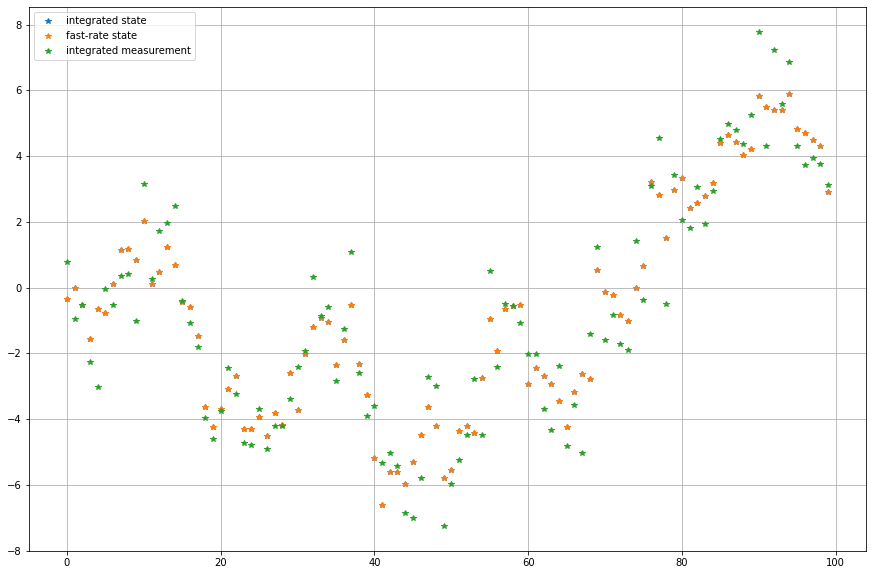

In [73]:
plt.figure(figsize = (15,10))

plt.plot(np.arange(0,T,l),h[:,0],'*',label = 'integrated state')
plt.plot(np.arange(T),x[:,0],'*',label = 'fast-rate state')
plt.plot(np.arange(0,T,l),y[:,0],'*',label = 'integrated measurement')
plt.legend()
plt.grid()

# Model simulation for Kalman Filter ($l$=1)

In [74]:
# steps = 100
# m0 = x_init  # Suitable initial mean
# P0 = cov_init # Suitable initial covariance

# LQ = linalg.cholesky(Q, lower=True)
# L0 = linalg.cholesky(P0, lower=True)

# T1 = np.zeros((steps,))
# X = np.zeros((steps,4))
# Y = np.zeros((steps,2))

# x_kf_test = m0 #+ L0 @ np.random.normal(size=(m0.shape))
# X[0,:] = x_init
# t = 0

# for n in range(1,steps):
# #     q = LQ @ np.random.normal(size=x_kf_test.shape)
#     xt_ = A @ X[n-1,:] + q[n-1]
# #     r = np.random.normal()
#     y = C @ xt_ + r[n]
#     t = t + 0.1
#     T1[n] = t
#     X[n,:] = xt_
#     Y[n,:] = y

# plt.clf()
# plt.plot(T1,X[:,0],T1,Y[:,0],'.',T1,X[:,1],':')
# plt.legend(['p','y','dp/dt'])

In [75]:
import jax.numpy as jnp

In [76]:
jnp.sum(A)

2022-09-29 10:19:23.522492: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


DeviceArray(5.4295006, dtype=float32)

# IMKF

In [90]:
M = np.array([[1, 2], [3, 4]])
M**2


array([[ 1,  4],
       [ 9, 16]])

In [91]:
np.linalg.matrix_power(M, 2)

array([[ 7, 10],
       [15, 22]])

In [92]:
l=4
A_bar_ = 0*A
for i in np.arange(1,l+1):
    A_bar_ += np.linalg.matrix_power(A, i)
A_bar = 1/l * A_bar_
A_bar

array([[0.75964725, 0.03291175, 0.02466102, 0.13729047],
       [1.13615188, 0.05692912, 0.05143418, 0.54107288],
       [0.75327739, 0.04547478, 0.04984932, 0.92237095],
       [0.05468924, 0.0062261 , 0.01199698, 0.81913265]])

In [88]:
np.linalg.matrix_power(A, 2)

array([[0.78294923, 0.03414967, 0.02566664, 0.11129612],
       [1.17888714, 0.05479345, 0.04598366, 0.52198039],
       [0.78393305, 0.04067083, 0.04044024, 0.93593066],
       [0.04434525, 0.00600503, 0.01217255, 0.84494788]])

In [89]:
A**2

array([[7.22330010e-01, 1.22500000e-03, 5.76000000e-04, 1.85761000e-03],
       [1.45950561e+00, 5.44644000e-03, 5.82169000e-03, 1.67035690e-01],
       [5.37435610e-01, 4.54276000e-03, 7.70884000e-03, 7.68602890e-01],
       [2.95840000e-04, 2.20900000e-05, 1.29960000e-04, 8.32291290e-01]])

In [78]:
x_hat = np.zeros((T,x_init.shape[0]))
x_hat[0] = x_init
Px = np.zeros((T,x_init.shape[0],x_init.shape[0]))
Px[0] = cov_init
h_hat = np.zeros((T//l,x_init.shape[0]))
Ph = np.zeros((T//l,x_init.shape[0],x_init.shape[0]))

A_bar = 0*A
for i in range(1,l+1):
    A_bar += 1/l * np.linalg.matrix_power(A, i)
M = np.zeros((l,A.shape[0], A.shape[1]))
for i in range(l):
    for j in range(l-i):
        M[i] += 1/l * np.linalg.matrix_power(A, j)
Q_M = 0*Q
for i in range(l):
    Q_M +=  M[i]@Q@M[i].T   

In [79]:
inverse = lambda a: np.linalg.solve(a, np.eye(a.shape[0]))
for t in range(l,T,l):
    
    # prediction
    h_hat_ = A_bar @ x_hat[t-l]
    P_h_   = A_bar @ Px[t-l] @ A_bar.T + Q_M
    
    #Update
    L = P_h_.T @ C.T @ inverse(C @ P_h_ @ C.T + R)
    h_hat[t//l] = h_hat_ + L @ (y[t//l] - C @ h_hat_)
    Ph[t//l] = P_h_ - L @ C @ P_h_

    #Smoothing
    for i in range(1,l+1):
        At = np.linalg.matrix_power(A, i) @ inverse(A_bar)
        x_hat[t-l+i] = At @ h_hat[t//l]
        C_bar = At @ L @ C 
        Qx1 = 0*Q
        Qx2 = 0*Q
        for j in range(1,i+1):
            Qx1 += (C_bar @ M[j-1] - np.linalg.matrix_power(A, i-j)) @ Q @ (C_bar @ M[j-1] - np.linalg.matrix_power(A, i-j)).T
        for j in range(i+1, l+1):
            Qx2 += C_bar @ M[j-1] @ Q @ (C_bar @ M[j-1]).T
        Qx3 = (At - C_bar) @ Q_M @ (At - C_bar).T

        Qx = Qx1 + Qx2 - Qx3
        Px[t-l+i] = At @ Ph[t//l] @ At.T + Qx


ValueError: x and y must have same first dimension, but have shapes (25,) and (100,)

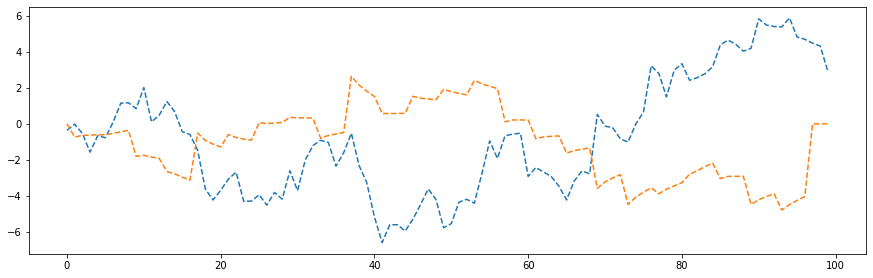

In [80]:
plt.figure(figsize = (15,10))

plt.subplot(211)
plt.plot(x[:,0],'--',label = 'fast-rate state')
plt.plot(x_hat[:,0],'--',label = 'xhat')
plt.plot(np.arange(0,T,l),h[:,0],'*',label = 'integrated state')
plt.plot(np.arange(0,T,l),h_hat[:,0],'*',label = 'h_hat')
plt.ylabel('First state')
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(x[:,3],'--',label = 'fast-rate state')
plt.plot(x_hat[:,3],'--',label = 'xhat')
plt.plot(np.arange(0,T,l),h[:,3],'*',label = 'integrated state')
plt.plot(np.arange(0,T,l),h_hat[:,3],'*',label = 'h_hat')
plt.ylabel('Last state')
plt.legend()
plt.grid()

# Kalman Filter

m = x_init
P = cov_init
kf_m = np.zeros((T, m.shape[0]))
kf_P = np.zeros((T, P.shape[0], P.shape[1]))
kf_m[0] = x_init
kf_P[0] = cov_init
for n in range(1,T):
    # Prediction
    m = A @ m
    P = A @ P @ A.T + Q
    # Update
    S = C @ P @ C.T + R
    K = P @ C.T @ linalg.inv(S)
    m = m + K @ (y[n] - C @ m)
    P = P - K @ S @ K.T
    kf_m[n,:] = m
    kf_P[n,:,:] = P

# Parallel integrated state estimation

In [ ]:
#filtering
a = kf.filteringInitializer(A_bar, Q_M, C, R, y, x_init, cov_init, T,l)
kf_res = kf.parallelScanAlgorithm(a, T, kf.filtering)

KF_m = []
KF_P = []
for k in range(l,len(kf_res),l): 
    KF_m.append(kf_res[k]['b'])
    KF_P.append(kf_res[k]['C'])
kf_m_par = np.array(KF_m).reshape(-1,4)

In [ ]:

plt.figure(figsize = (10,5))
plt.subplot(211)
plt.plot(kf_m_par[:,0],'--',label = 'parallel integrated state estimation')
plt.plot(h_hat[1:,0], '*', label = 'sequential integrated state estimation')
plt.ylabel('$h_1$')
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(kf_m_par[:,3],'--',label = 'parallel integrated state estimation')
plt.plot(h_hat[1:,3], '*', label = 'sequential integrated state estimation')
plt.ylabel('$h_4$')
plt.legend()
plt.grid()

In [ ]:
np.testing.assert_allclose(h_hat[:,0][1:], kf_m_par[:,0], 1e-2)

In [ ]:
h_hat[:,0][1:].shape

In [ ]:
kf_m_par[:,0].shape